In [16]:
from nltk.corpus import stopwords 
import pandas as pd
import numpy as  np
import matplotlib as plt
import re
import string

#jupyter path
cols = ['sentiment','id','date','query_string','user','original_tweets']
df_encoding = "latin-1"

df = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding =df_encoding, header=None, names=cols)
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df = df.sample(frac=1, replace=True, random_state=1)
df.head()

,sentiment,original_tweets
128037,0,Oh really don't wanna be awake
491755,0,Trying to amuse my cousin. It's not working! a...
470924,0,@JonasAustralia i wanted to win! congrats to ...
491263,0,That's it!! I can't take it no more!! After su...
836489,4,@beckybootsx i hope your not drinking alcohol!...


In [17]:
from tensorflow.python.client import device_lib
physical_devices = device_lib.list_local_devices()
print(physical_devices[1])

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2247832371
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2371064379465048162
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"



In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

config = tf.compat.v1.ConfigProto(allow_soft_placement=True,device_count = {'GPU' : 1})
config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)


"""config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)"""

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4657329765225457900
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2247832371
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5669628850416816940
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


"config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) \nsess = tf.Session(config=config) \nkeras.backend.set_session(sess)"

## Define usefull functions


In [19]:
import nltk
#import spacy
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

# set stop words for english language
stop_words = set(stopwords.words("english"))

# function to remove punctuation
def remove_punctuations(text):
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

def remove_stopwords(text):

    list_of_words = [word for word in text.split(' ') if word not in stop_words]
    words_to_text = " ".join(list_of_words)
    return words_to_text

def remove_numbers(text):
    clear_text = ''.join([i for i in text if not i.isdigit()])
    return clear_text

def do_lem(text):
    text = ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])
    return text


def clean_text(text):    
    # regex dictionary
    regex = {
        "urls": r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",
        "mentions": r"@[A-Za-z0-9]+",
        "hashtags": r"#[A-Za-z0-9]+",
        "whitespaces": "\s+"
    }
    text = str(text).lower()
    text = re.sub(regex['urls'], '', text)
    text = re.sub(regex['mentions'], '', text)
    text = re.sub(regex['hashtags'], '', text)
    text = remove_stopwords(text) 
    text = remove_punctuations(text)
    text = remove_numbers(text)
    text = re.sub(regex['whitespaces'], ' ', text).strip()
    text = do_lem(text)

    return text

def create_subsets(dataset, features, labels, num_classes, train_size=0, valid_size=0, test_size=0):
    subsets = {}
    
    # Define a size for your train set 
    train_n = int(train_size * len(dataset))
    valid_n = int(valid_size * len(dataset))
    test_n = int(test_size * len(dataset))
    
    #train_test split
    subsets['X_train'] = dataset[features][:train_n]
    subsets['X_valid'] = dataset[features][train_n:train_n+valid_n]
    subsets['X_test'] = dataset[features][train_n+valid_n:train_n+valid_n+test_n]

    # Categorically encode labels
    subsets['Y_train'] = to_categorical(dataset[labels][:train_n].values, num_classes)
    subsets['Y_valid'] = to_categorical(dataset[labels][train_n:train_n+valid_n].values, num_classes)
    subsets['Y_test'] = to_categorical(dataset[labels][train_n+valid_n:train_n+valid_n+test_n].values, num_classes)
    return subsets

def words_to_sequences(max_sentence_length, subsets):
    seq_subsets = {}
    vocab_size = 0
    global tokenizer 
    tokenizer = Tokenizer()
    for key, value in subsets.items():
        if key.startswith('X'):
            # create vocabulary based on word frequency
            #   -word_counts: Dictionary of words and their corresponding counts.
            #   -word_docs: Dictionary of words and their corresponding documents appeared in.
            #   -word_index: Dictionary of words and their uniquely assigned integers.
            #   -document_count: Count of the total number of documents that were used to fit the Tokenizer.
            if key.startswith('X_train'):
                tokenizer.fit_on_texts(list(value))
            
            # texts_to_sequences assigns integers to words for each document
            sequence = tokenizer.texts_to_sequences(value)
            # padding to prepare sequences of same length
            sequence = pad_sequences(sequence, maxlen = max_sentence_length)
            seq_subsets[key] = sequence
            
            if len(tokenizer.word_index) > vocab_size:
                vocab_size = len(tokenizer.word_index)

    return seq_subsets, vocab_size+1;

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ichristod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ichristod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ichristod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Cleaning

In [20]:
# copy dataframe
df_clean = df.copy(deep=True)

# clean text
df_clean['tweets'] = df_clean['original_tweets'].apply(clean_text)

# transform labels
df_clean['sentiment'] = df_clean['sentiment'].apply(lambda x: x if x<4 else 1)

# keep max length of words and sentences
words_length = max(len(w) for w in df_clean['tweets'])
sentence_length = max(len(w.split(' ')) for w in df_clean['tweets'])

print("max chars in a tweet:", words_length)
print("max num of words in a tweet:", sentence_length)

df_clean.head(100)

max chars in a tweet: 317
max num of words in a tweet: 37


,sentiment,original_tweets,tweets
128037,0,Oh really don't wanna be awake,oh really wanna awake
491755,0,Trying to amuse my cousin. It's not working! a...,trying amuse cousin working he playing halo wo
470924,0,@JonasAustralia i wanted to win! congrats to ...,wanted win congrats anyways
491263,0,That's it!! I can't take it no more!! After su...,thats it cant take more summer school im talki...
836489,1,@beckybootsx i hope your not drinking alcohol!...,hope drinking alcohol lol
...,...,...,...
1053847,1,Breakfast with my mommy,breakfast mommy
992577,1,"1 tut down, 123981 projects to go!!",tut down project go
275825,0,@melody1976 I'm jealous!! I have 4 weeks to w...,im jealous week wait
501507,0,'s heart is aching,s heart aching


In [21]:
# remove necessary columns & reset indexes
df_clean.drop(['original_tweets'],axis=1,inplace=True)
df_clean.reset_index(drop=True)

,sentiment,tweets
0,0,oh really wanna awake
1,0,trying amuse cousin working he playing halo wo
2,0,wanted win congrats anyways
3,0,thats it cant take more summer school im talki...
4,1,hope drinking alcohol lol
...,...,...
1599995,0,even get free vegetable first day pick job
1599996,0,kathy amp sarah taking train philly interview ...
1599997,0,yeah hard done car truck much harder parent ri...
1599998,0,im u store need payment option all demo free a...


In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from collections import defaultdict

features = 'tweets'
labels = 'sentiment'

#create appropriate subsets
initial_subsets = create_subsets(dataset=df_clean, features=features, labels=labels, 
                   train_size=0.6, valid_size=0.2, test_size=0.2, num_classes=2)

# convert features (text) to sequences
seq_subsets, vocab_size = words_to_sequences(sentence_length, subsets=initial_subsets)

## Load Glove

In [23]:
# load the whole embedding into memory
glove_dict = dict()
f = open('glove.twitter.27B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    if word in tokenizer.word_index:
        coefs = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(glove_dict))

Loaded 88621 word vectors.


## Create Embedding Matrix 

In [24]:
# weight matrix of words in tweets
embedding_matrix = np.zeros((vocab_size, 50))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    


In [25]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RNN
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import LSTMCell 

embed_dim = 50
lstm_out = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=50,weights=[embedding_matrix],input_length=sentence_length,trainable=False)) 
#model.add(LSTM(lstm_out, dropout=0.25,recurrent_dropout=0))
model.add(RNN(LSTMCell(lstm_out)))
model.add(Dropout(0.3))
#model.add(GRU(100))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 37, 50)            11913800  
_________________________________________________________________
rnn_1 (RNN)                  (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 11,974,402
Trainable params: 60,602
Non-trainable params: 11,913,800
_________________________________________________________________


In [26]:
import keras
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

history = model.fit(seq_subsets['X_train'], initial_subsets['Y_train'],validation_data 
                    = (seq_subsets['X_valid'],initial_subsets['Y_valid']), shuffle=True, 
                    epochs = 50, batch_size=500, callbacks=[es])


Epoch 1/50
1920/1920 [==============================] - 174s 90ms/step - loss: 0.5413 - accuracy: 0.7222 - val_loss: 0.4859 - val_accuracy: 0.7615
Epoch 2/50
1920/1920 [==============================] - 176s 92ms/step - loss: 0.4805 - accuracy: 0.7665 - val_loss: 0.4681 - val_accuracy: 0.7733
Epoch 3/50
1920/1920 [==============================] - 170s 88ms/step - loss: 0.4681 - accuracy: 0.7740 - val_loss: 0.4624 - val_accuracy: 0.7776
Epoch 4/50
1920/1920 [==============================] - 168s 88ms/step - loss: 0.4589 - accuracy: 0.7801 - val_loss: 0.4570 - val_accuracy: 0.7811
Epoch 5/50
1920/1920 [==============================] - 167s 87ms/step - loss: 0.4529 - accuracy: 0.7840 - val_loss: 0.4560 - val_accuracy: 0.7828
Epoch 6/50
1920/1920 [==============================] - 170s 89ms/step - loss: 0.4466 - accuracy: 0.7881 - val_loss: 0.4483 - val_accuracy: 0.7862
Epoch 7/50
1920/1920 [==============================] - 174s 90ms/step - loss: 0.4419 - accuracy: 0.7909 - val_loss: 0

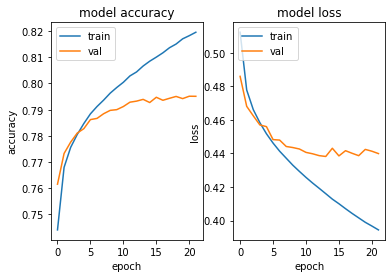

In [27]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') # True/False

# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [29]:
model.evaluate(seq_subsets['X_test'],initial_subsets['Y_test'])

10000/10000 [==============================] - 251s 25ms/step - loss: 0.4418 - accuracy: 0.7947


[0.4417976140975952, 0.7947031259536743]

In [30]:
# save model and architecture to single file
model.save("rnn_lstm.h5")
print("Saved model to disk")

Saved model to disk
